# PHYS 434 Lab 7&8 Angela Zhou

In [62]:
# import library
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import scipy
from scipy import stats
import h5py
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from scipy.stats import poisson
from scipy.stats import norm
import scipy.stats as st

## Event selection optimization 
### You and your lab partner should pick different pT (transverse momentum) samples (one uses low-pT sampels and the other use high-pT samples) for this lab. In each pT sample, there are dedicated training samples for event selection optimization. All studies should be carried out by normalizing Higgs and QCD samples in each pT sample to given expected yields accordingly (See Dataset descriptions).
I chose to work with the high PT: Sample_pt_1000_1200 dataset.

In [2]:
# open the file of interest, and use pickle loading
file_qcd = open ("qcd_100000_pt_1000_1200.pkl",'rb')
file_higgs = open ("higgs_100000_pt_1000_1200.pkl",'rb')
dict_qcd = pickle.load(file_qcd)
dict_higgs = pickle.load(file_higgs)

# list all keys of the files
print(dict_qcd.keys())
print(dict_higgs.keys())

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')
Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')


In [3]:
## extra data from the files
# background dataset QCD
pt_qcd = dict_qcd['pt']
eta_qcd = dict_qcd['eta']
phi_qcd = dict_qcd['phi']
mass_qcd = dict_qcd['mass']
ee2_qcd = dict_qcd['ee2']
ee3_qcd = dict_qcd['ee3']
d2_qcd = dict_qcd['d2']
angularity_qcd = dict_qcd['angularity']
t1_qcd = dict_qcd['t1']
t2_qcd = dict_qcd['t2']
t3_qcd = dict_qcd['t3']
t21_qcd = dict_qcd['t21']
t32_qcd = dict_qcd['t32']
KtDeltaR_qcd = dict_qcd['KtDeltaR']

# signal dataset higgs
pt_higgs = dict_higgs['pt']
eta_higgs = dict_higgs['eta']
phi_higgs = dict_higgs['phi']
mass_higgs = dict_higgs['mass']
ee2_higgs = dict_higgs['ee2']
ee3_higgs = dict_higgs['ee3']
d2_higgs = dict_higgs['d2']
angularity_higgs = dict_higgs['angularity']
t1_higgs = dict_higgs['t1']
t2_higgs = dict_higgs['t2']
t3_higgs = dict_higgs['t3']
t21_higgs = dict_higgs['t21']
t32_higgs = dict_higgs['t32']
KtDeltaR_higgs = dict_higgs['KtDeltaR']


In [4]:
print(mass_higgs.size)
print(mass_qcd.size)

100000
100000


## 1. Make a stacked histogram plot for the feature variable: mass

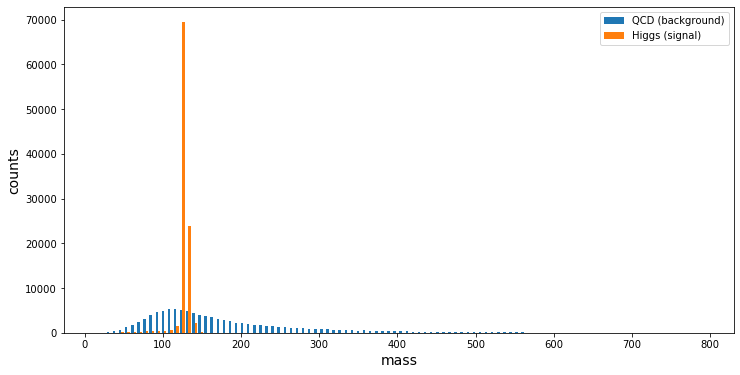

In [5]:
fig,ax = plt.subplots(figsize=(12,6))
ax.hist([mass_qcd, mass_higgs], bins = 100, label = ["QCD (background)", "Higgs (signal)"]);
ax.legend();
ax.set_xlabel("mass", fontsize = 14);
ax.set_ylabel("counts", fontsize = 14);

### Evaluate expected significance without any event selection.
### A. Use Poisson statistics for significance calculation

In [6]:
## Calculate expected significance
# Expected yields (number of data points we expect)
N_higgs = 50
N_qcd = 2000

# first calculate probability
probability = poisson.sf(N_higgs + N_qcd, N_qcd)
# probability = poisson.cdf(N_qcd, N_higgs + N_qcd)

# convert probability to significance
significance = abs(norm.isf(probability))
# significance = abs(norm.ppf(probability))
print("Significance is: " + str(round(significance,3)))

Significance is: 1.128


### B. Compare your number of $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$. If they are equivalent, explain your findings.

In [7]:
# calculate N_higgs / sqrt(N_QCD)
n = N_higgs/np.sqrt(N_qcd)
print("N_higgs / sqrt(N_QCD) is: " + str(round(n,3)))

N_higgs / sqrt(N_QCD) is: 1.118


Our calculated result of significance using Poisson statistics is pretty close to $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$. Therefore, $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ is a good approximation of significance for Poisson statistics.

## 2. Identify mass cuts to optimize the expected significance.
### A&B. Try different mass cuts systematically. Evaluate expeced significance for each set of mass cuts
From part 1 above, we proved $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ is a good approximation of significance, so in this part I will use $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ to calculate the significance for different mass cuts. 

In [8]:
# Write a function that calculate expected significance for a given mass cut
def evalSig_mass(low, high, total = 100000): # 2 parameters: lower and higher bound of the mass cut
    
    # initialize some useful consts
    expected_higgs = 50 # number of expected higgs data in the original 100000 size dataset
    expected_qcd = 2000 # number of expected qcd data in the original 100000 size dataset
    
    # calculate mean in this mass cut for higgs data
    counts_higgs = 0
    for i in mass_higgs:
        if (i > low and i <= high):
            counts_higgs = counts_higgs + 1
    
    # calculate mean in this mass cut for qcd data
    counts_qcd = 0
    for j in mass_qcd:
        if (j > low and j <= high):
            counts_qcd = counts_qcd + 1
    
    # renormalization
    N_higgs = counts_higgs* (expected_higgs / total)
    N_qcd = counts_qcd * (expected_qcd / total)
    
    sig = N_higgs / np.sqrt(N_qcd)
    
    return sig

In [9]:
print("Significance in mass cut (50,200): " + str(round(evalSig_mass(50,200),3)))
print("Significance in mass cut (100,200): " + str(round(evalSig_mass(100,200),3)))
print("Significance in mass cut (150,200): " + str(round(evalSig_mass(150,200),5)))

Significance in mass cut (50,200): 1.34
Significance in mass cut (100,200): 1.537
Significance in mass cut (150,200): 0.00013


### C. Identify the set of the mass cuts which give you the highest significance.
After trying out various mass cuts, the set of mass cuts below gives the highest significance. This mass cut range is about where the higgs data has its peak.

In [10]:
print("Significance in mass cut (125,129): " + str(round(evalSig_mass(125,129),3)))

Significance in mass cut (125,129): 4.335


## 3. Make stacked histogram plots for the reset of features
### A. Set A of plots without any event selection
### Can you identify another feature as discriminative as mass feature (i.e. equal or better significance after feature cut)
To know which feature has high discrimination power, I will make histograms of all 14 features without any event selection in the cell below.  

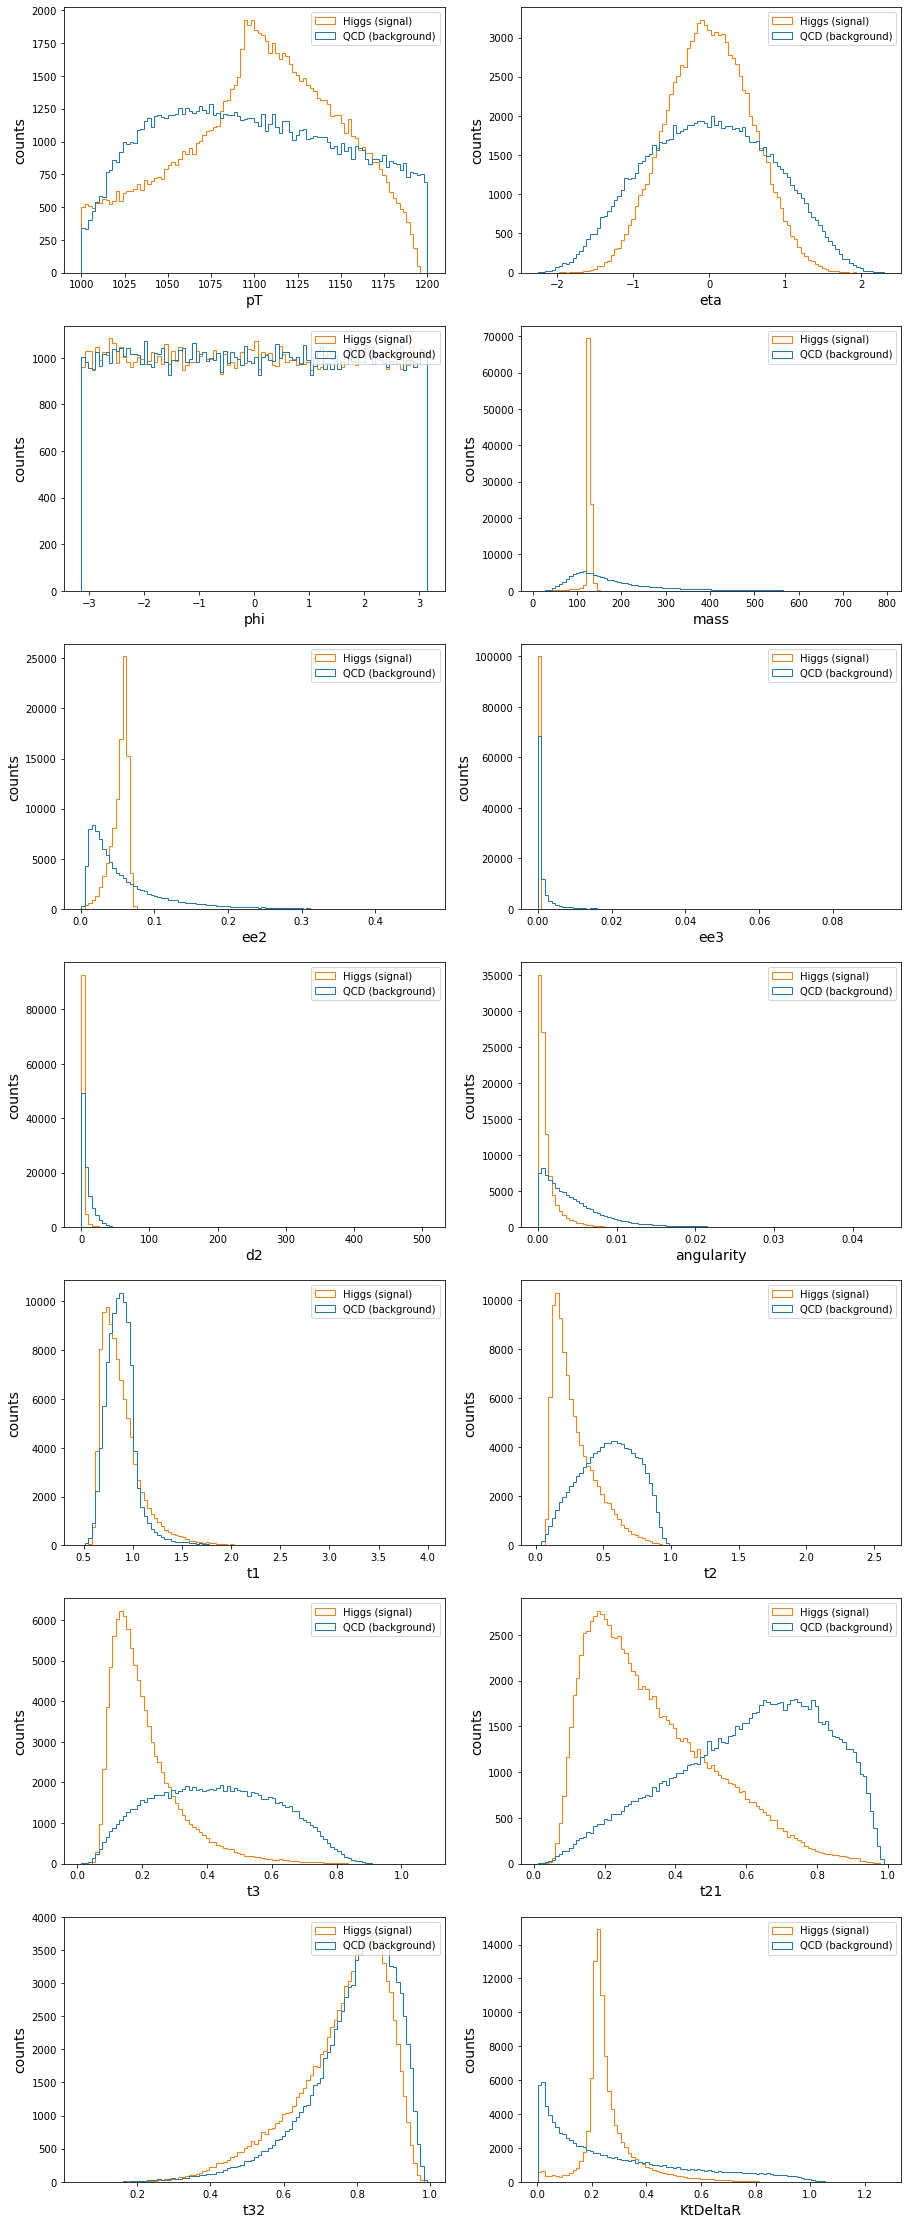

In [11]:
# create a figure with 14 subplots
fig, ax = plt.subplots(7, 2, figsize= (15, 40))

ax[0,0].hist([pt_qcd, pt_higgs], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[0,0].legend();
ax[0,0].set_xlabel("pT", fontsize = 14);
ax[0,0].set_ylabel("counts", fontsize = 14);

ax[0,1].hist([eta_qcd, eta_higgs], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[0,1].legend();
ax[0,1].set_xlabel("eta", fontsize = 14);
ax[0,1].set_ylabel("counts", fontsize = 14);

ax[1,0].hist([phi_qcd, phi_higgs], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[1,0].legend();
ax[1,0].set_xlabel("phi", fontsize = 14);
ax[1,0].set_ylabel("counts", fontsize = 14);

ax[1,1].hist([mass_qcd, mass_higgs], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[1,1].legend();
ax[1,1].set_xlabel("mass", fontsize = 14);
ax[1,1].set_ylabel("counts", fontsize = 14);

ax[2,0].hist([ee2_qcd, ee2_higgs], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[2,0].legend();
ax[2,0].set_xlabel("ee2", fontsize = 14);
ax[2,0].set_ylabel("counts", fontsize = 14);

ax[2,1].hist([ee3_qcd, ee3_higgs], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[2,1].legend();
ax[2,1].set_xlabel("ee3", fontsize = 14);
ax[2,1].set_ylabel("counts", fontsize = 14);

ax[3,0].hist([d2_qcd, d2_higgs], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[3,0].legend();
ax[3,0].set_xlabel("d2", fontsize = 14);
ax[3,0].set_ylabel("counts", fontsize = 14);

ax[3,1].hist([angularity_qcd, angularity_higgs], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[3,1].legend();
ax[3,1].set_xlabel("angularity", fontsize = 14);
ax[3,1].set_ylabel("counts", fontsize = 14);

ax[4,0].hist([t1_qcd, t1_higgs], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[4,0].legend();
ax[4,0].set_xlabel("t1", fontsize = 14);
ax[4,0].set_ylabel("counts", fontsize = 14);

ax[4,1].hist([t2_qcd, t2_higgs], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[4,1].legend();
ax[4,1].set_xlabel("t2", fontsize = 14);
ax[4,1].set_ylabel("counts", fontsize = 14);

ax[5,0].hist([t3_qcd, t3_higgs], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[5,0].legend();
ax[5,0].set_xlabel("t3", fontsize = 14);
ax[5,0].set_ylabel("counts", fontsize = 14);

ax[5,1].hist([t21_qcd, t21_higgs], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[5,1].legend();
ax[5,1].set_xlabel("t21", fontsize = 14);
ax[5,1].set_ylabel("counts", fontsize = 14);

ax[6,0].hist([t32_qcd, t32_higgs], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[6,0].legend();
ax[6,0].set_xlabel("t32", fontsize = 14);
ax[6,0].set_ylabel("counts", fontsize = 14);

ax[6,1].hist([KtDeltaR_qcd, KtDeltaR_higgs], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[6,1].legend();
ax[6,1].set_xlabel("KtDeltaR", fontsize = 14);
ax[6,1].set_ylabel("counts", fontsize = 14);

From the plots above, we can see feature "t21" also has a high discrimination power. So, in the cell below I will try to calculate the highest significance we can get using t21 cuts. 

In [12]:
# Write a function that calculate expected significance for a given mass cut
def evalSig_t21(low, high, total = 100000): # 2 parameters: lower and higher bound of the mass cut
    expected_higgs = 50
    expected_qcd = 2000
    
    # calculate mean in this mass cut for higgs data
    counts_higgs = 0
    for i in t21_higgs:
        if (i > low and i <= high):
            counts_higgs = counts_higgs + 1
    
    # calculate mean in this mass cut for qcd data
    counts_qcd = 0
    for j in t21_qcd:
        if (j > low and j <= high):
            counts_qcd = counts_qcd + 1
    
    # renormalization
    N_higgs = counts_higgs* (expected_higgs / total)
    N_qcd = counts_qcd * (expected_qcd / total)
    
    sig = N_higgs / np.sqrt(N_qcd)
    
    return sig

In [13]:
print("Significance in t21 cut (0,0.4): " + str(round(evalSig_t21(0,0.4),3)))
print("Significance in t21 cut (0.4,0.8): " + str(round(evalSig_t21(0.4,0.8),3)))
print("Significance in t21 cut (0.1,0.3): " + str(round(evalSig_t21(0.1,0.3),3)))

Significance in t21 cut (0,0.4): 1.787
Significance in t21 cut (0.4,0.8): 0.435
Significance in t21 cut (0.1,0.3): 1.768


In [14]:
print("The highest significance we can get using t21 cuts is " + str(round(evalSig_t21(0.06,0.34),3)) + " with t21 cut (0.06,0.34)")

The highest significance we can get using t21 cuts is 1.825 with t21 cut (0.06,0.34)


### B. Set B of plots with your optimal mass cuts
### Can you identify additional feature to further improve expected signifiance?
The optimal mass cuts calculated above is (125,129) with significance = 4.335. In the cell below, I will make a plot only contain data within the optimal mass cuts. 

In [15]:
# set the optimal range
optimalMass_low = 125
optimalMass_high = 129

# create optimal arrays for higgs and qcd data to select the data within this range
optimal_higgs = (mass_higgs > optimalMass_low) & (mass_higgs < optimalMass_high)
optimal_qcd = (mass_qcd > optimalMass_low) & (mass_qcd < optimalMass_high)
massCut_higgs = mass_higgs[optimal_higgs]
massCut_qcd = mass_qcd[optimal_qcd]

# print out result to check
# print(optimal)
# print(massCut)
# print()
# print(mass_higgs)

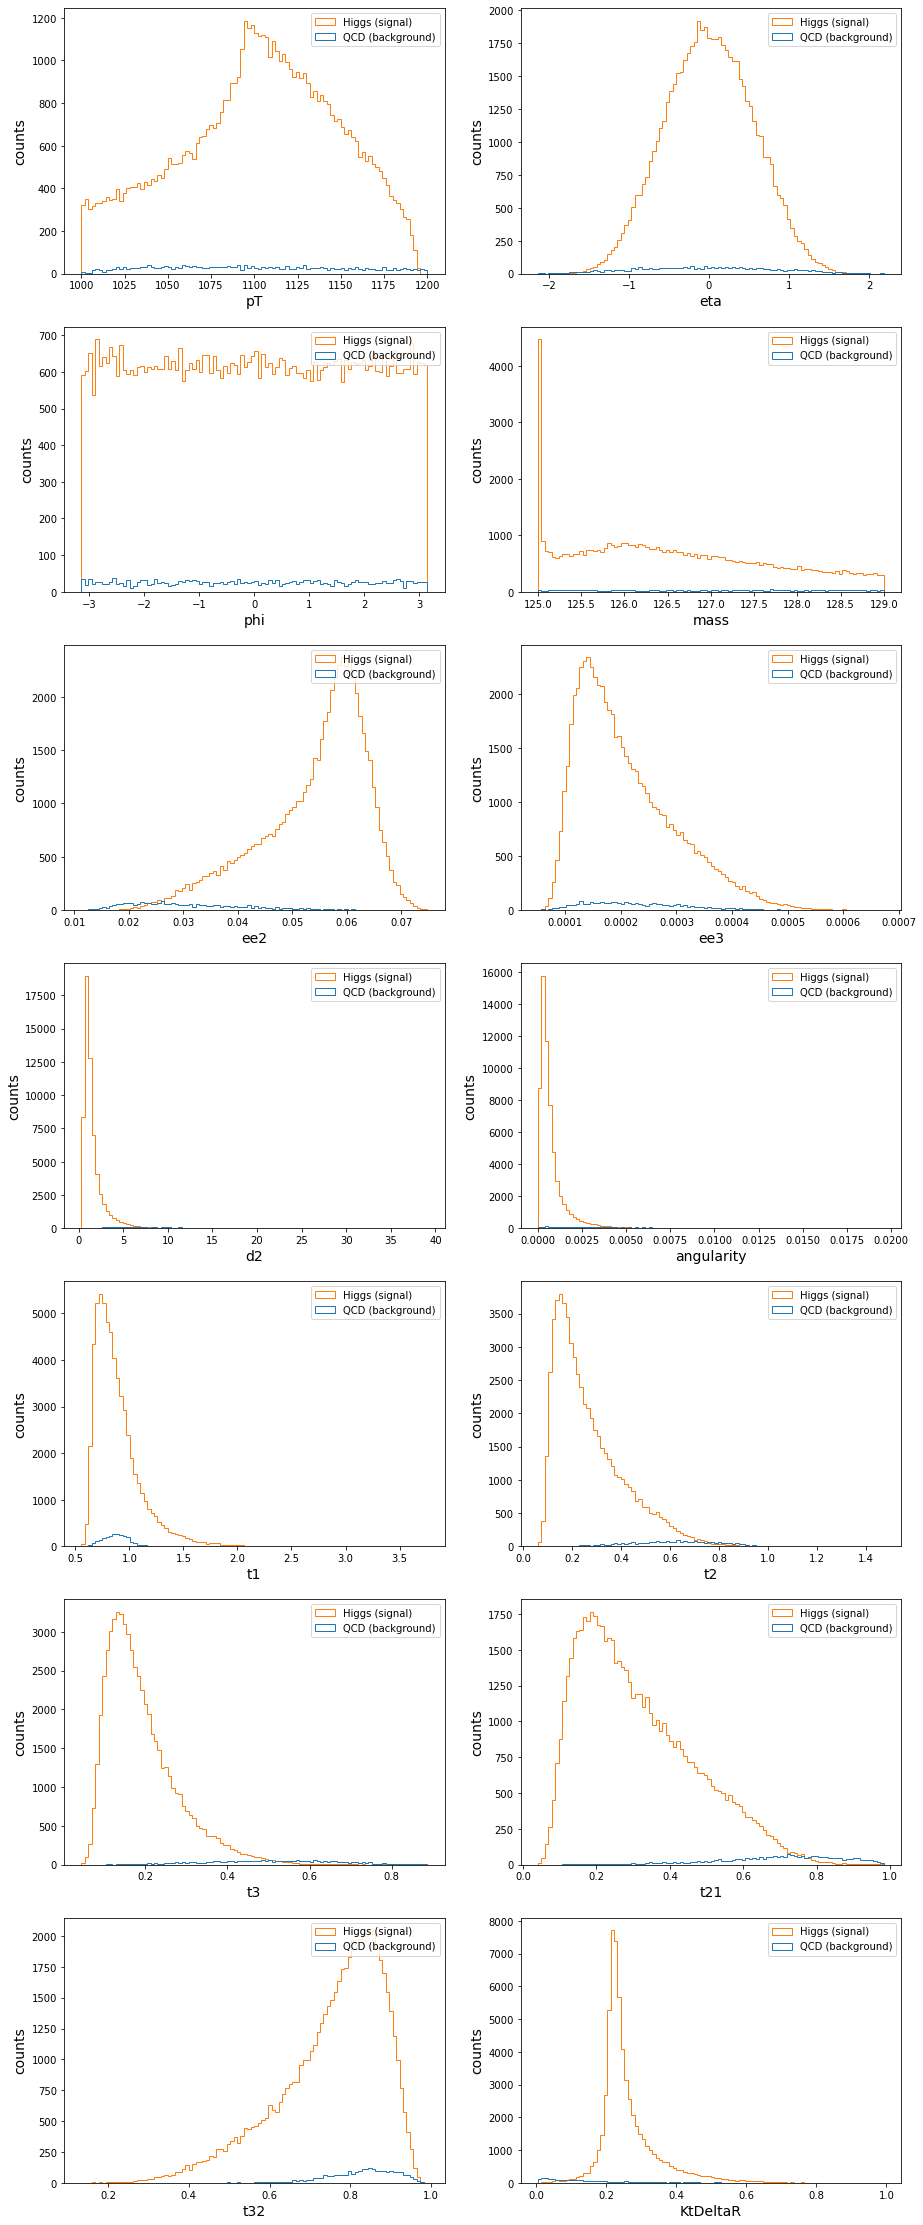

In [16]:
# create a figure with 14 subplots
fig, ax = plt.subplots(7, 2, figsize= (15, 40))

ax[0,0].hist([pt_qcd[optimal_qcd], pt_higgs[optimal_higgs]], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[0,0].legend();
ax[0,0].set_xlabel("pT", fontsize = 14);
ax[0,0].set_ylabel("counts", fontsize = 14);

ax[0,1].hist([eta_qcd[optimal_qcd], eta_higgs[optimal_higgs]], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[0,1].legend();
ax[0,1].set_xlabel("eta", fontsize = 14);
ax[0,1].set_ylabel("counts", fontsize = 14);

ax[1,0].hist([phi_qcd[optimal_qcd], phi_higgs[optimal_higgs]], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[1,0].legend();
ax[1,0].set_xlabel("phi", fontsize = 14);
ax[1,0].set_ylabel("counts", fontsize = 14);

ax[1,1].hist([mass_qcd[optimal_qcd], mass_higgs[optimal_higgs]], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[1,1].legend();
ax[1,1].set_xlabel("mass", fontsize = 14);
ax[1,1].set_ylabel("counts", fontsize = 14);

ax[2,0].hist([ee2_qcd[optimal_qcd], ee2_higgs[optimal_higgs]], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[2,0].legend();
ax[2,0].set_xlabel("ee2", fontsize = 14);
ax[2,0].set_ylabel("counts", fontsize = 14);

ax[2,1].hist([ee3_qcd[optimal_qcd], ee3_higgs[optimal_higgs]], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[2,1].legend();
ax[2,1].set_xlabel("ee3", fontsize = 14);
ax[2,1].set_ylabel("counts", fontsize = 14);

ax[3,0].hist([d2_qcd[optimal_qcd], d2_higgs[optimal_higgs]], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[3,0].legend();
ax[3,0].set_xlabel("d2", fontsize = 14);
ax[3,0].set_ylabel("counts", fontsize = 14);

ax[3,1].hist([angularity_qcd[optimal_qcd], angularity_higgs[optimal_higgs]], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[3,1].legend();
ax[3,1].set_xlabel("angularity", fontsize = 14);
ax[3,1].set_ylabel("counts", fontsize = 14);

ax[4,0].hist([t1_qcd[optimal_qcd], t1_higgs[optimal_higgs]], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[4,0].legend();
ax[4,0].set_xlabel("t1", fontsize = 14);
ax[4,0].set_ylabel("counts", fontsize = 14);

ax[4,1].hist([t2_qcd[optimal_qcd], t2_higgs[optimal_higgs]], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[4,1].legend();
ax[4,1].set_xlabel("t2", fontsize = 14);
ax[4,1].set_ylabel("counts", fontsize = 14);

ax[5,0].hist([t3_qcd[optimal_qcd], t3_higgs[optimal_higgs]], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[5,0].legend();
ax[5,0].set_xlabel("t3", fontsize = 14);
ax[5,0].set_ylabel("counts", fontsize = 14);

ax[5,1].hist([t21_qcd[optimal_qcd], t21_higgs[optimal_higgs]], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[5,1].legend();
ax[5,1].set_xlabel("t21", fontsize = 14);
ax[5,1].set_ylabel("counts", fontsize = 14);

ax[6,0].hist([t32_qcd[optimal_qcd], t32_higgs[optimal_higgs]], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[6,0].legend();
ax[6,0].set_xlabel("t32", fontsize = 14);
ax[6,0].set_ylabel("counts", fontsize = 14);

ax[6,1].hist([KtDeltaR_qcd[optimal_qcd], KtDeltaR_higgs[optimal_higgs]], bins = 100, histtype = "step", label = ["QCD (background)", "Higgs (signal)"]);
ax[6,1].legend();
ax[6,1].set_xlabel("KtDeltaR", fontsize = 14);
ax[6,1].set_ylabel("counts", fontsize = 14);

From the plots above we can see that we made a huge improvement on keeping the signal (higgs) data and eliminating as much background (qcd) as we can. Now, all 14 features have higher discrimination power than before, using any of the 14 features will improve the expected significance.

## 4. Optimize event selections using multiple features (if necessary)
### A. Find a set of feature cuts which can help you to achieve the best significance.
From looking at the plots above, I think feature "d2" will give me a significantly better significance. So, in the cell below, I will find a set of d2 cuts that gives me the highest significance. 

In [17]:
# Write a function that calculate expected significance for a given mass cut
def evalSig_d2(low, high, total = 100000): # 2 parameters: lower and higher bound of the mass cut
    expected_higgs = 50
    expected_qcd = 2000
    
    # calculate mean in this mass cut for higgs data
    counts_higgs = 0
    for i in d2_higgs[optimal_higgs]:
        if (i > low and i <= high):
            counts_higgs = counts_higgs + 1
    
    # calculate mean in this mass cut for qcd data
    counts_qcd = 0
    for j in d2_qcd[optimal_qcd]:
        if (j > low and j <= high):
            counts_qcd = counts_qcd + 1
    
    # renormalization
    N_higgs = counts_higgs* (expected_higgs / total)
    N_qcd = counts_qcd * (expected_qcd / total)
    
    sig = N_higgs / np.sqrt(N_qcd)
    
    return sig

In [18]:
print("Significance in d2 cut (0,5): " + str(round(evalSig_d2(0,5),3)))
print("Significance in d2 cut (5,10): " + str(round(evalSig_d2(5,10),3)))
print("Significance in d2 cut (3,10): " + str(round(evalSig_d2(3,10),3)))

Significance in d2 cut (0,5): 8.598
Significance in d2 cut (5,10): 0.228
Significance in d2 cut (3,10): 0.607


In [19]:
print("The highest significance we can get using d2 cuts is " + str(round(evalSig_d2(0.4,1.34),3)) + " with d2 cut (0.4,1.34)")

The highest significance we can get using d2 cuts is 38.924 with d2 cut (0.4,1.34)


From looking at the plots, feature "angularity" is also discriminative. In the cell below, I will find a set of angularity cuts that gives the highest significance.

In [20]:
# Write a function that calculate expected significance for a given mass cut
def evalSig_t21_optimal(low, high, total = 100000): # 2 parameters: lower and higher bound of the mass cut
    expected_higgs = 50
    expected_qcd = 2000
    
    # calculate mean in this mass cut for higgs data
    counts_higgs = 0
    for i in t21_higgs[optimal_higgs]:
        if (i > low and i <= high):
            counts_higgs = counts_higgs + 1
    
    # calculate mean in this mass cut for qcd data
    counts_qcd = 0
    for j in t21_qcd[optimal_qcd]:
        if (j > low and j <= high):
            counts_qcd = counts_qcd + 1
    
    # renormalization
    N_higgs = counts_higgs* (expected_higgs / total)
    N_qcd = counts_qcd * (expected_qcd / total)
    
    sig = N_higgs / np.sqrt(N_qcd)
    
    return sig

In [21]:
print("Significance in t21 cut (0,0.4): " + str(round(evalSig_t21_optimal(0,0.4),3)))
print("Significance in t21 cut (0.4,0.8): " + str(round(evalSig_t21_optimal(0.4,0.8),3)))
print("Significance in t21 cut (0.1,0.3): " + str(round(evalSig_t21_optimal(0.1,0.3),3)))

Significance in t21 cut (0,0.4): 11.773
Significance in t21 cut (0.4,0.8): 1.463
Significance in t21 cut (0.1,0.3): 14.082


In [22]:
print("The highest significance we can get using t21 cuts is " + str(round(evalSig_t21_optimal(0.06,0.34),3)) + " with t21 cut (0.06,0.34)")

The highest significance we can get using t21 cuts is 14.163 with t21 cut (0.06,0.34)


### B. Compare significance (before/after event selection) dervied in your pT samples to your lab partner. Describe your findings.
The significance increased significantly after event selection. <br>
Below is a table comparing the two high significance I have calculated using feature "t21" cuts with and without event selection. The event selection here uses optimal mass cuts (125,129). <br>
With feature "d2" cuts, after event selection we can even achive a significance as high as 38.924.

In [23]:
# construct data array for table
significance = np.array([1.825, 14.163]) 

# display the table
table = pd.DataFrame(data=significance, index=["no event selection", "with optimal mass cuts"], columns=["highest significance"])
display(table)

,highest significance
no event selection,1.825
with optimal mass cuts,14.163


# Lab 8
## Pseudo-experiment data analysis 
### Using your optimized event selection, hunt for your signal by using one of the pseduo-experiment dataset. For each task below, you will choose one of the observed data from your specific pT sample to perform the analysis.

In [50]:
## import pseudo experiments data
# high lumi data
highLumi = pd.read_hdf("data_highLumi_pt_1000_1200.h5")
data_highLumi = highLumi.to_numpy()
pt_highLumi = data_highLumi[:,0]
eta_highLumi = data_highLumi[:,1]
phi_highLumi = data_highLumi[:,2]
mass_highLumi = data_highLumi[:,3]
ee2_highLumi = data_highLumi[:,4]
ee3_highLumi = data_highLumi[:,5]
d2_highLumi = data_highLumi[:,6]
angularity_highLumi = data_highLumi[:,7]
t1_highLumi = data_highLumi[:,8]
t2_highLumi = data_highLumi[:,9]
t3_highLumi = data_highLumi[:,10]
t21_highLumi = data_highLumi[:,11]
t32_highLumi = data_highLumi[:,12]
KtDeltaR_highLumi = data_highLumi[:,13]

# low kumi data
lowLumi = pd.read_hdf("data_lowLumi_pt_1000_1200.h5")
data_lowLumi = lowLumi.to_numpy()
pt_lowLumi = data_lowLumi[:,0]
eta_lowLumi = data_lowLumi[:,1]
phi_lowLumi = data_lowLumi[:,2]
mass_lowLumi = data_lowLumi[:,3]
ee2_lowLumi = data_lowLumi[:,4]
ee3_lowLumi = data_lowLumi[:,5]
d2_lowLumi = data_lowLumi[:,6]
angularity_lowLumi = data_lowLumi[:,7]
t1_lowLumi = data_lowLumi[:,8]
t2_lowLumi = data_lowLumi[:,9]
t3_lowLumi = data_lowLumi[:,10]
t21_lowLumi = data_lowLumi[:,11]
t32_lowLumi = data_lowLumi[:,12]
KtDeltaR_lowLumi = data_lowLumi[:,13]

# print(highLumi)
# print(data)
print(pt_highLumi.size)
observedYields_highLumi = pt_highLumi.size
print(pt_lowLumi.size)
observedYields_lowLumi = pt_lowLumi.size

4066
442


## 1. High luminosity data
### A. Focus on each feature of your event selection. Plot observed data, overlap with expected signal and background (normalized to observed yields) without event selection.
The observed data is the pseudo experiment data, expected signal is the higgs data, and the background is the qcd data.<br>
Normalizing the higgs and qcd data to the observed yields meaning the sum of all the higgs data and the sum of all the qcd data should both equal to the number of data points in the pseudo data, in this case 4066. To do that, I rescaled the y values of higgs data and qcd data by multiplying 4066/100000.

In [51]:
weights_highLumi = np.full(100000, observedYields_highLumi/100000); # create an array of shape = 100000, filled with the same value of 4066
weights_lowLumi = np.full(100000, observedYields_lowLumi/100000); # create an array of shape = 100000, filled with the same value of 442

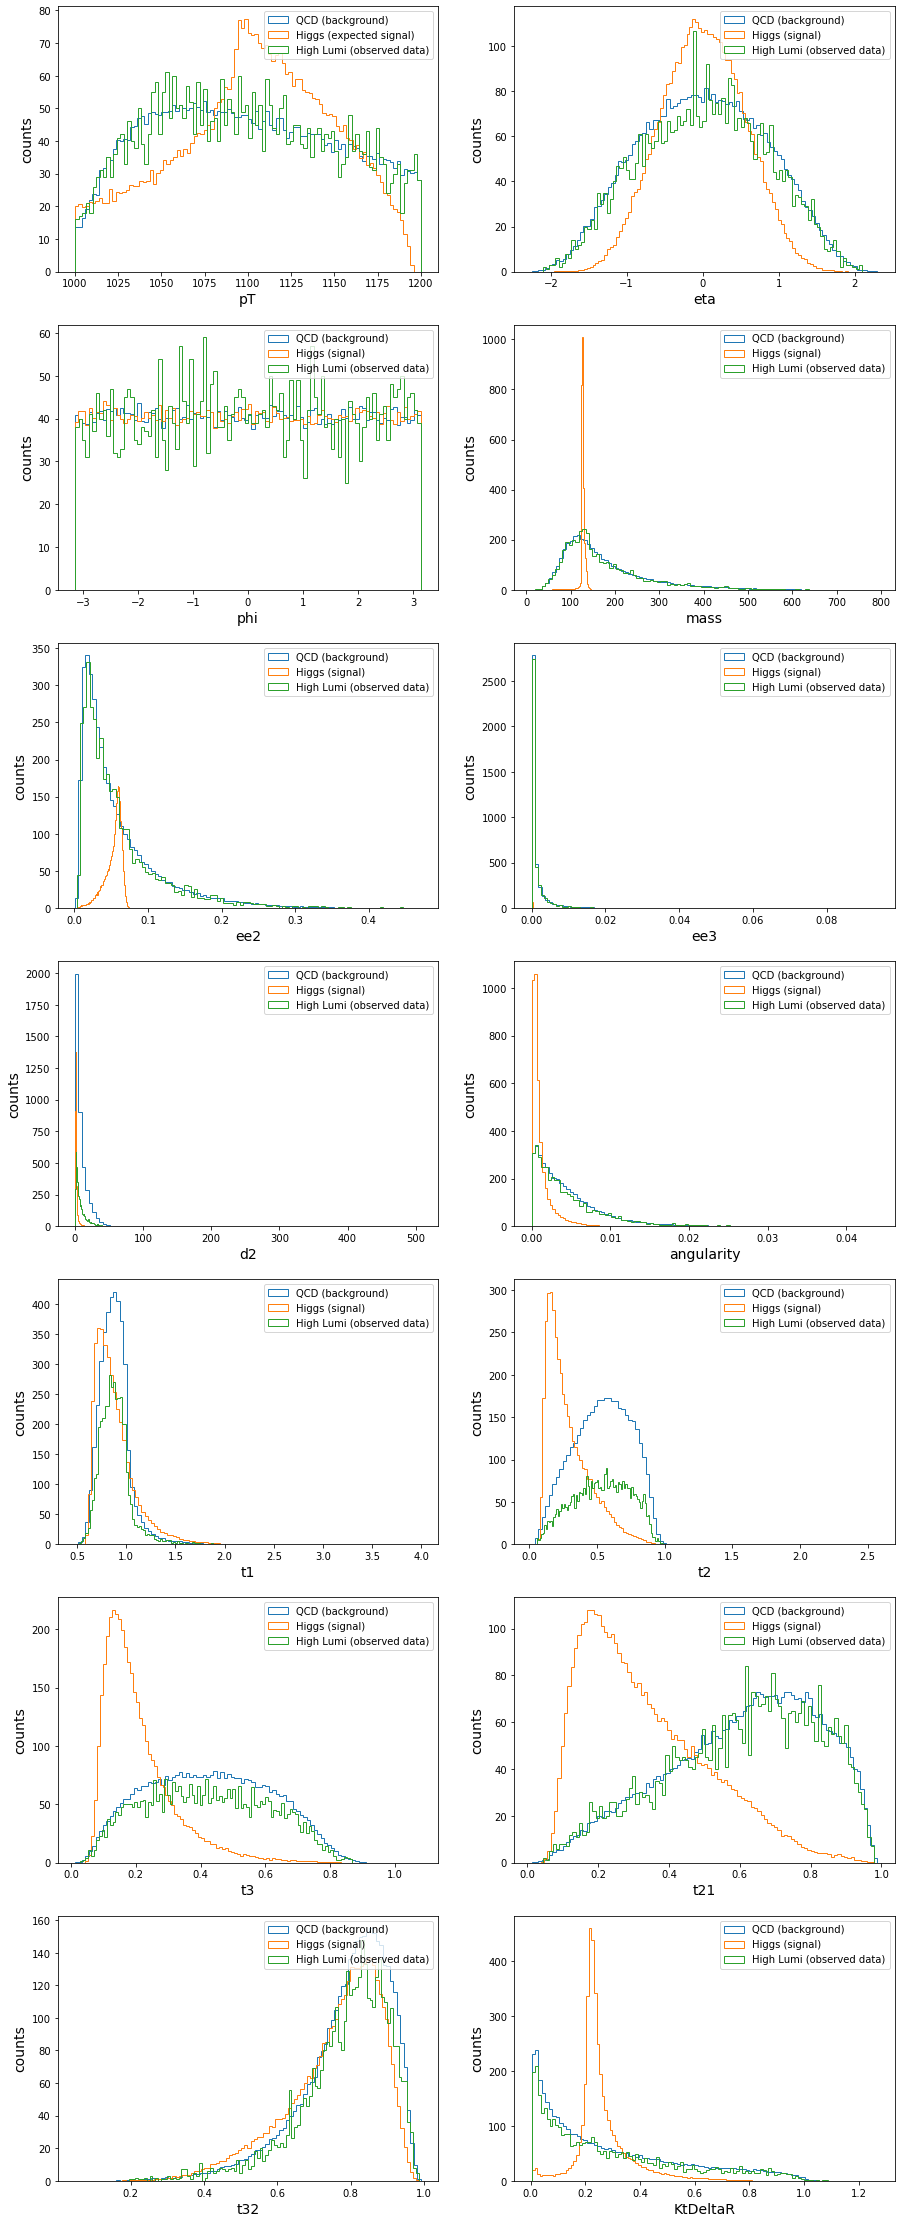

In [52]:
# create a figure with 14 subplots
fig, ax = plt.subplots(7, 2, figsize= (15, 40))

ax[0,0].hist(pt_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_highLumi);
ax[0,0].hist(pt_higgs, bins = 100, histtype = "step", label = ["Higgs (expected signal)"], weights = weights_highLumi);
ax[0,0].hist(pt_highLumi, bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[0,0].legend();
ax[0,0].set_xlabel("pT", fontsize = 14);
ax[0,0].set_ylabel("counts", fontsize = 14);

ax[0,1].hist(eta_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_highLumi);
ax[0,1].hist(eta_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_highLumi);
ax[0,1].hist(eta_highLumi, bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[0,1].legend();
ax[0,1].set_xlabel("eta", fontsize = 14);
ax[0,1].set_ylabel("counts", fontsize = 14);

ax[1,0].hist(phi_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_highLumi);
ax[1,0].hist(phi_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_highLumi);
ax[1,0].hist(phi_highLumi, bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[1,0].legend();
ax[1,0].set_xlabel("phi", fontsize = 14);
ax[1,0].set_ylabel("counts", fontsize = 14);

ax[1,1].hist(mass_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_highLumi);
ax[1,1].hist(mass_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_highLumi);
ax[1,1].hist(mass_highLumi, bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[1,1].legend();
ax[1,1].set_xlabel("mass", fontsize = 14);
ax[1,1].set_ylabel("counts", fontsize = 14);

ax[2,0].hist(ee2_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_highLumi);
ax[2,0].hist(ee2_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_highLumi);
ax[2,0].hist(ee2_highLumi, bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[2,0].legend();
ax[2,0].set_xlabel("ee2", fontsize = 14);
ax[2,0].set_ylabel("counts", fontsize = 14);

ax[2,1].hist(ee3_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_highLumi);
ax[2,1].hist(ee3_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_highLumi);
ax[2,1].hist(ee3_highLumi, bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[2,1].legend();
ax[2,1].set_xlabel("ee3", fontsize = 14);
ax[2,1].set_ylabel("counts", fontsize = 14);

ax[3,0].hist(d2_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_highLumi);
ax[3,0].hist(d2_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_highLumi);
ax[3,0].hist(d2_highLumi, bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[3,0].legend();
ax[3,0].set_xlabel("d2", fontsize = 14);
ax[3,0].set_ylabel("counts", fontsize = 14);

ax[3,1].hist(angularity_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_highLumi);
ax[3,1].hist(angularity_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_highLumi);
ax[3,1].hist(angularity_highLumi, bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[3,1].legend();
ax[3,1].set_xlabel("angularity", fontsize = 14);
ax[3,1].set_ylabel("counts", fontsize = 14);

ax[4,0].hist(t1_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_highLumi);
ax[4,0].hist(t1_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_highLumi);
ax[4,0].hist(t1_highLumi, bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[4,0].legend();
ax[4,0].set_xlabel("t1", fontsize = 14);
ax[4,0].set_ylabel("counts", fontsize = 14);

ax[4,1].hist(t2_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_highLumi);
ax[4,1].hist(t2_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_highLumi);
ax[4,1].hist(t2_highLumi, bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[4,1].legend();
ax[4,1].set_xlabel("t2", fontsize = 14);
ax[4,1].set_ylabel("counts", fontsize = 14);

ax[5,0].hist(t3_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_highLumi);
ax[5,0].hist(t3_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_highLumi);
ax[5,0].hist(t3_highLumi, bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[5,0].legend();
ax[5,0].set_xlabel("t3", fontsize = 14);
ax[5,0].set_ylabel("counts", fontsize = 14);

ax[5,1].hist(t21_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_highLumi);
ax[5,1].hist(t21_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_highLumi);
ax[5,1].hist(t21_highLumi, bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[5,1].legend();
ax[5,1].set_xlabel("t21", fontsize = 14);
ax[5,1].set_ylabel("counts", fontsize = 14);

ax[6,0].hist(t32_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_highLumi);
ax[6,0].hist(t32_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_highLumi);
ax[6,0].hist(t32_highLumi, bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[6,0].legend();
ax[6,0].set_xlabel("t32", fontsize = 14);
ax[6,0].set_ylabel("counts", fontsize = 14);

ax[6,1].hist(KtDeltaR_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_highLumi);
ax[6,1].hist(KtDeltaR_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_highLumi);
ax[6,1].hist(KtDeltaR_highLumi, bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[6,1].legend();
ax[6,1].set_xlabel("KtDeltaR", fontsize = 14);
ax[6,1].set_ylabel("counts", fontsize = 14);

### B. Plot observed data, overlap with expected signal and background (normalized to observed yields) with optimal event selection.
I used optimal mass cut (125,129) I found in Lab 7 for the optimal event selection here.

In [27]:
optimal_highLumi = (mass_highLumi > optimalMass_low) & (mass_highLumi < optimalMass_high)
# print(optimal_highLumi)
optimal_weight = pt_highLumi[optimal_highLumi].size/100000
# print(pt_qcd[optimal_qcd].size)
# print(pt_higgs[optimal_higgs].size)

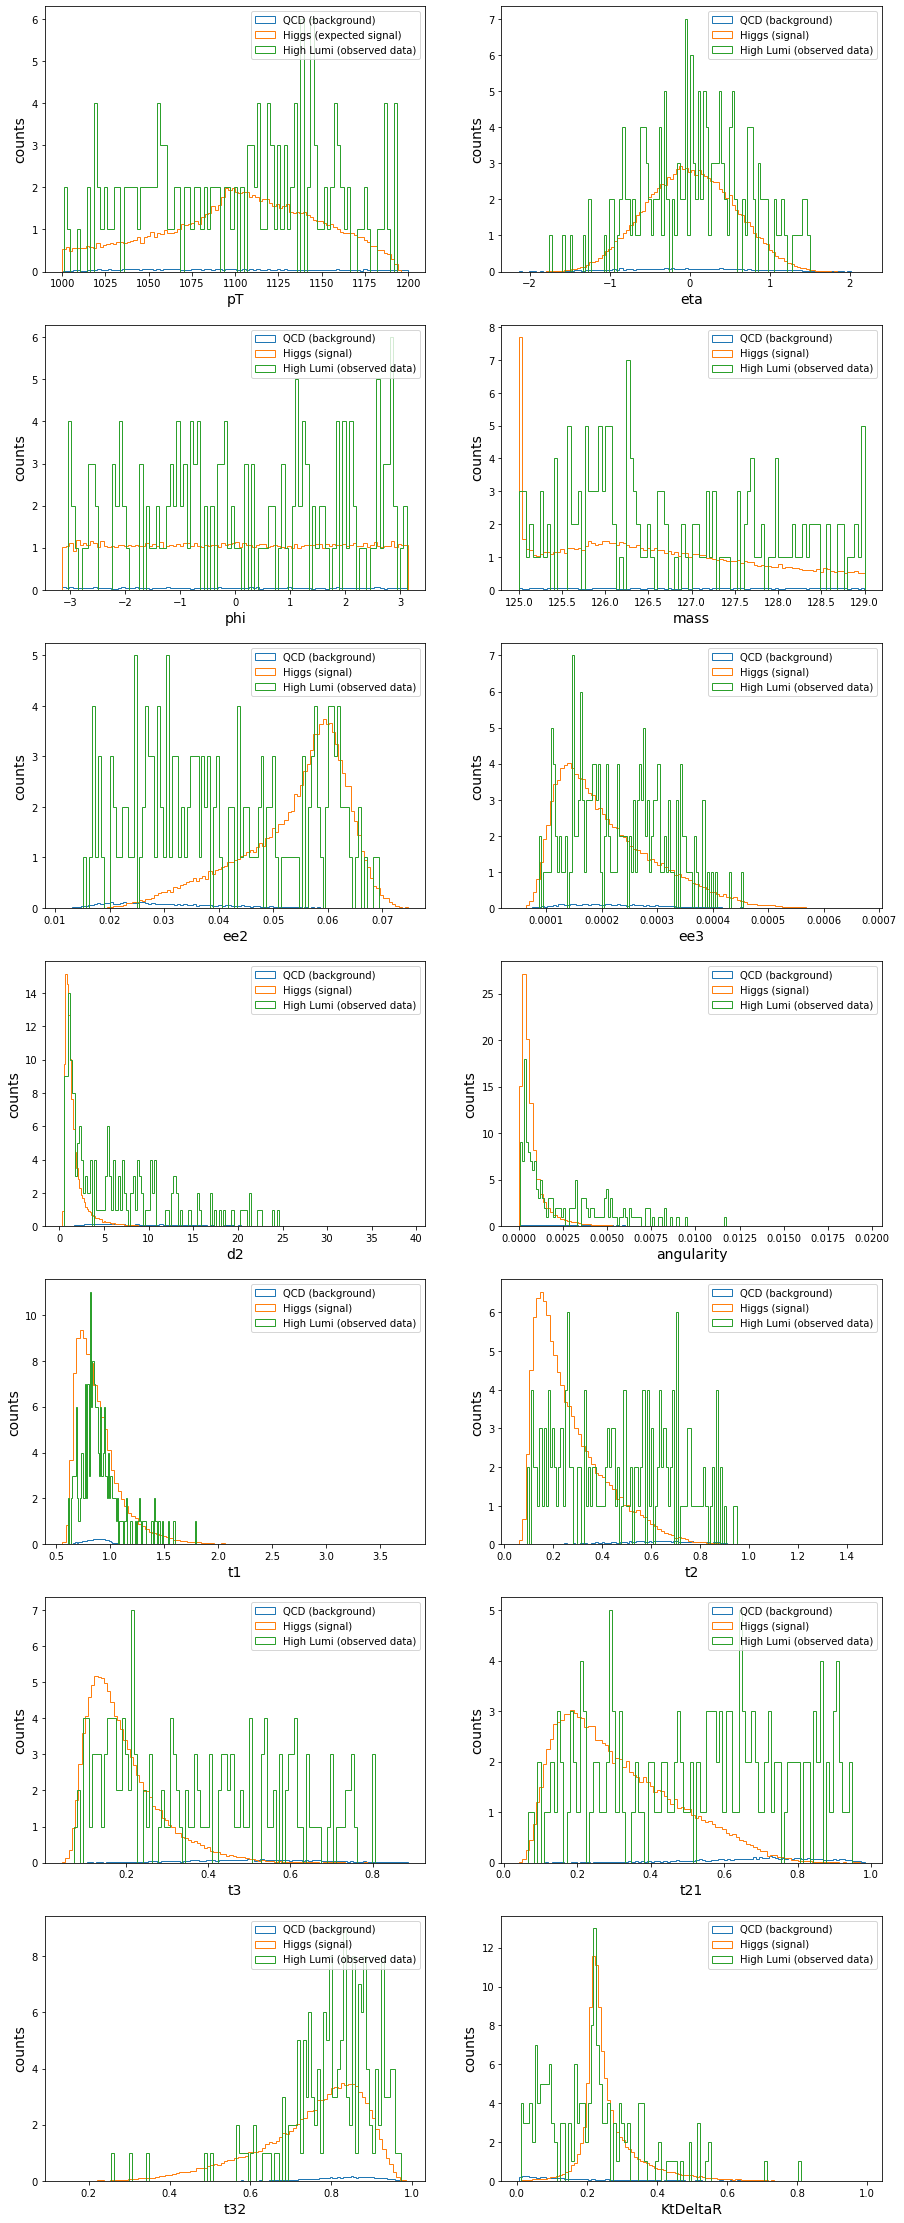

In [28]:
# create a figure with 14 subplots
fig, ax = plt.subplots(7, 2, figsize= (15, 40))

ax[0,0].hist(pt_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(pt_qcd[optimal_qcd].size,optimal_weight));
ax[0,0].hist(pt_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (expected signal)"], weights = np.full(pt_higgs[optimal_higgs].size,optimal_weight));
ax[0,0].hist(pt_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[0,0].legend();
ax[0,0].set_xlabel("pT", fontsize = 14);
ax[0,0].set_ylabel("counts", fontsize = 14);

ax[0,1].hist(eta_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(eta_qcd[optimal_qcd].size, optimal_weight));
ax[0,1].hist(eta_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(eta_higgs[optimal_higgs].size,optimal_weight));
ax[0,1].hist(eta_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[0,1].legend();
ax[0,1].set_xlabel("eta", fontsize = 14);
ax[0,1].set_ylabel("counts", fontsize = 14);

ax[1,0].hist(phi_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(phi_qcd[optimal_qcd].size, optimal_weight));
ax[1,0].hist(phi_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(phi_higgs[optimal_higgs].size,optimal_weight));
ax[1,0].hist(phi_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[1,0].legend();
ax[1,0].set_xlabel("phi", fontsize = 14);
ax[1,0].set_ylabel("counts", fontsize = 14);

ax[1,1].hist(mass_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(mass_qcd[optimal_qcd].size, optimal_weight));
ax[1,1].hist(mass_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(mass_higgs[optimal_higgs].size, optimal_weight));
ax[1,1].hist(mass_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[1,1].legend();
ax[1,1].set_xlabel("mass", fontsize = 14);
ax[1,1].set_ylabel("counts", fontsize = 14);

ax[2,0].hist(ee2_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(ee2_qcd[optimal_qcd].size, optimal_weight));
ax[2,0].hist(ee2_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(ee2_higgs[optimal_higgs].size, optimal_weight));
ax[2,0].hist(ee2_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[2,0].legend();
ax[2,0].set_xlabel("ee2", fontsize = 14);
ax[2,0].set_ylabel("counts", fontsize = 14);

ax[2,1].hist(ee3_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(ee3_qcd[optimal_qcd].size, optimal_weight));
ax[2,1].hist(ee3_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(ee3_higgs[optimal_higgs].size, optimal_weight));
ax[2,1].hist(ee3_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[2,1].legend();
ax[2,1].set_xlabel("ee3", fontsize = 14);
ax[2,1].set_ylabel("counts", fontsize = 14);

ax[3,0].hist(d2_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(d2_qcd[optimal_qcd].size, optimal_weight));
ax[3,0].hist(d2_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(d2_qcd[optimal_higgs].size, optimal_weight));
ax[3,0].hist(d2_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[3,0].legend();
ax[3,0].set_xlabel("d2", fontsize = 14);
ax[3,0].set_ylabel("counts", fontsize = 14);

ax[3,1].hist(angularity_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(angularity_qcd[optimal_qcd].size, optimal_weight));
ax[3,1].hist(angularity_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(angularity_higgs[optimal_higgs].size, optimal_weight));
ax[3,1].hist(angularity_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[3,1].legend();
ax[3,1].set_xlabel("angularity", fontsize = 14);
ax[3,1].set_ylabel("counts", fontsize = 14);

ax[4,0].hist(t1_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(t1_qcd[optimal_qcd].size, optimal_weight));
ax[4,0].hist(t1_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(t1_higgs[optimal_higgs].size, optimal_weight));
ax[4,0].hist(t1_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[4,0].legend();
ax[4,0].set_xlabel("t1", fontsize = 14);
ax[4,0].set_ylabel("counts", fontsize = 14);

ax[4,1].hist(t2_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(t2_qcd[optimal_qcd].size, optimal_weight));
ax[4,1].hist(t2_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(t2_higgs[optimal_higgs].size, optimal_weight));
ax[4,1].hist(t2_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[4,1].legend();
ax[4,1].set_xlabel("t2", fontsize = 14);
ax[4,1].set_ylabel("counts", fontsize = 14);

ax[5,0].hist(t3_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(t3_qcd[optimal_qcd].size, optimal_weight));
ax[5,0].hist(t3_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(t3_higgs[optimal_higgs].size, optimal_weight));
ax[5,0].hist(t3_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[5,0].legend();
ax[5,0].set_xlabel("t3", fontsize = 14);
ax[5,0].set_ylabel("counts", fontsize = 14);

ax[5,1].hist(t21_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(t21_qcd[optimal_qcd].size, optimal_weight));
ax[5,1].hist(t21_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(t21_higgs[optimal_higgs].size, optimal_weight));
ax[5,1].hist(t21_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[5,1].legend();
ax[5,1].set_xlabel("t21", fontsize = 14);
ax[5,1].set_ylabel("counts", fontsize = 14);

ax[6,0].hist(t32_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(t32_qcd[optimal_qcd].size, optimal_weight));
ax[6,0].hist(t32_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(t32_higgs[optimal_higgs].size, optimal_weight));
ax[6,0].hist(t32_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[6,0].legend();
ax[6,0].set_xlabel("t32", fontsize = 14);
ax[6,0].set_ylabel("counts", fontsize = 14);

ax[6,1].hist(KtDeltaR_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(KtDeltaR_qcd[optimal_qcd].size, optimal_weight));
ax[6,1].hist(KtDeltaR_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(KtDeltaR_higgs[optimal_higgs].size, optimal_weight));
ax[6,1].hist(KtDeltaR_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[6,1].legend();
ax[6,1].set_xlabel("KtDeltaR", fontsize = 14);
ax[6,1].set_ylabel("counts", fontsize = 14);

### C. Evaluate observed significance and compare your results to expectation

In [45]:
# Write a function that calculate observed significance for a given mass cut
def evalObservedSig_mass(low, high, total = 100000): # 2 parameters: lower and higher bound of the mass cut
    
    # calculate N_higgs in this mass cut 
    counts_higgs = 0
    for i in mass_higgs:
        if (i > low and i <= high):
            counts_higgs = counts_higgs + 1
            
    # calculate number of observed data in this mass cut
    counts_highLumi = 0
    for k in mass_highLumi:
        if (k > low and k <= high):
            counts_highLumi = counts_highLumi + 1
            
    # renormalization
    N_higgs = counts_higgs* (50 / total)
    N_qcd = counts_highLumi * (2000 / 4066)
    
    sig = N_higgs / np.sqrt(N_qcd)
    
    return sig

In [46]:
print("Expected significance in mass cut (125,129): " + str(round(evalSig_mass(125,129),3)))
print("Observed significance in mass cut (125,129): " + str(round(evalObservedSig_mass(125,129),3)))

Expected significance in mass cut (125,129): 4.335
Observed significance in mass cut (125,129): 3.35


## 2. Low luminosity data
### A. Focus on each feature of your event selection. Plot observed data, overlap with expected signal and background (normalized to observed yields) without event selection.

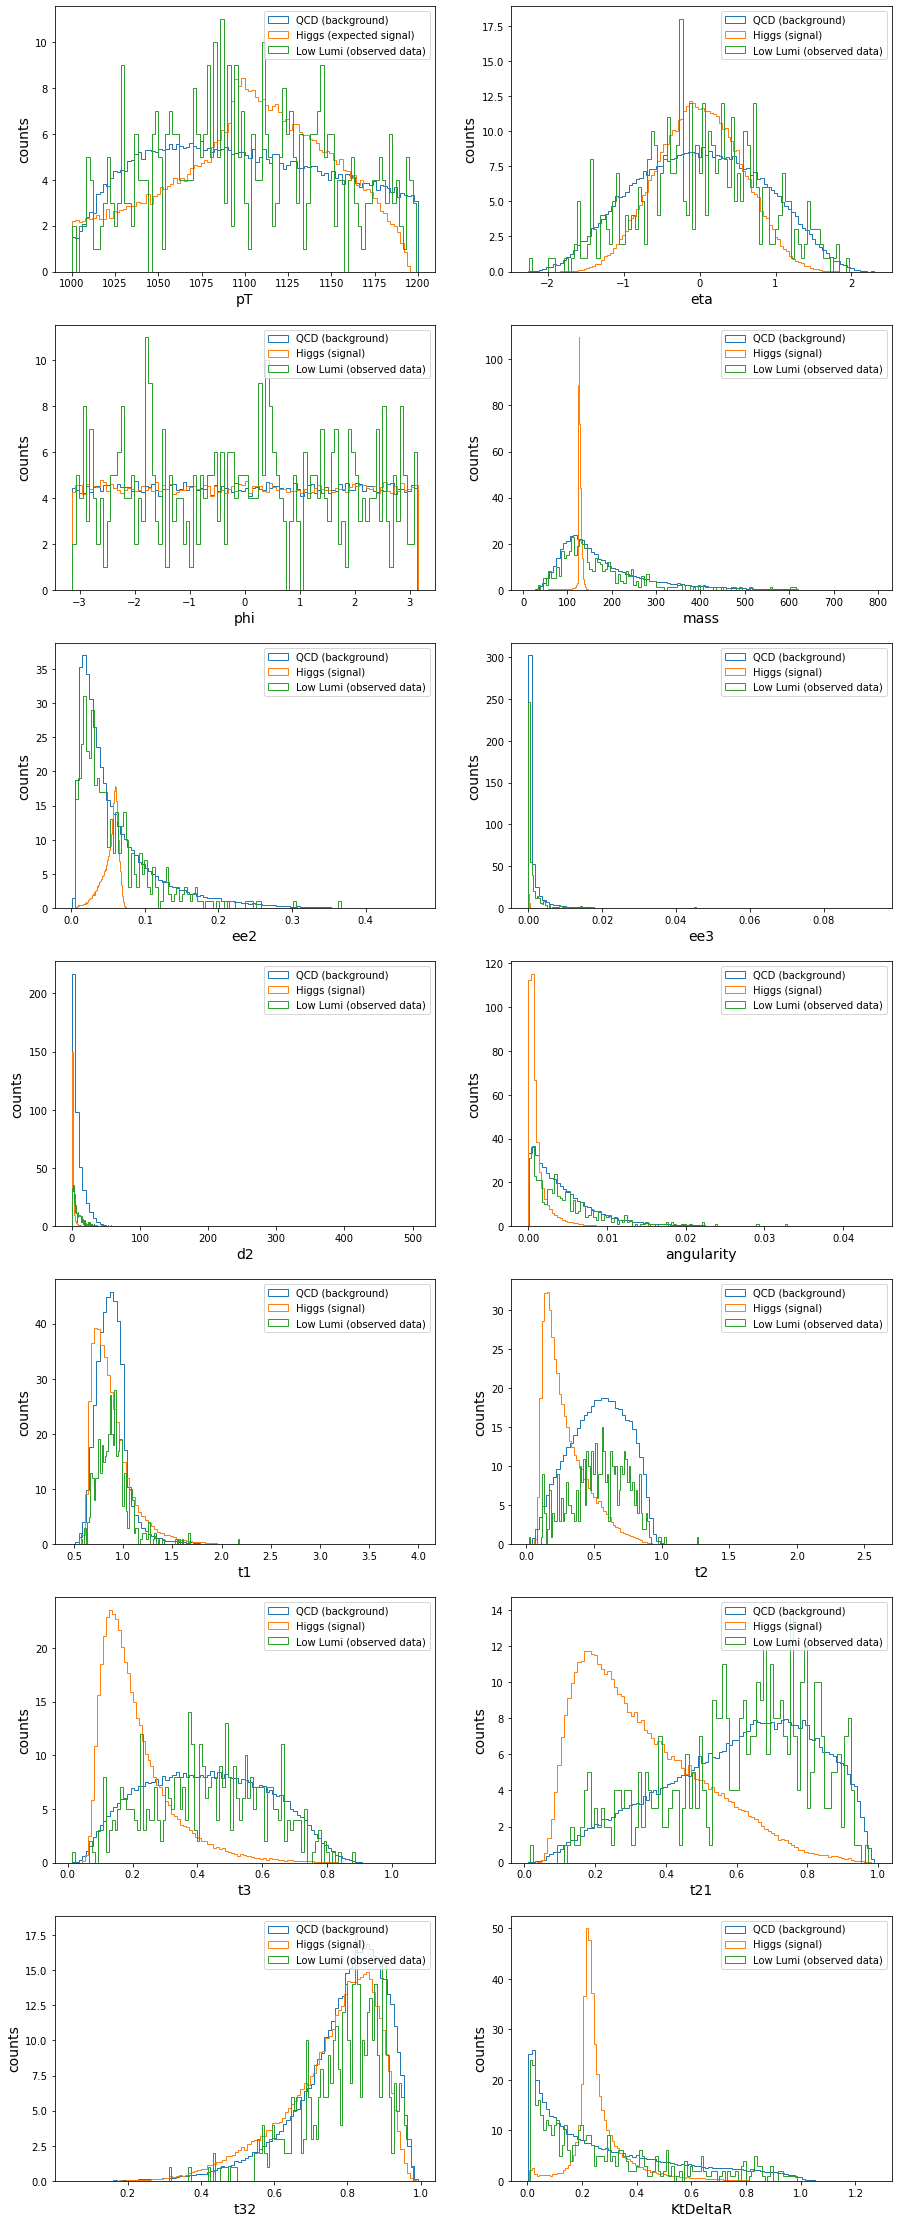

In [53]:
# create a figure with 14 subplots
fig, ax = plt.subplots(7, 2, figsize= (15, 40))

ax[0,0].hist(pt_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_lowLumi);
ax[0,0].hist(pt_higgs, bins = 100, histtype = "step", label = ["Higgs (expected signal)"], weights = weights_lowLumi);
ax[0,0].hist(pt_lowLumi, bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[0,0].legend();
ax[0,0].set_xlabel("pT", fontsize = 14);
ax[0,0].set_ylabel("counts", fontsize = 14);

ax[0,1].hist(eta_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_lowLumi);
ax[0,1].hist(eta_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_lowLumi);
ax[0,1].hist(eta_lowLumi, bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[0,1].legend();
ax[0,1].set_xlabel("eta", fontsize = 14);
ax[0,1].set_ylabel("counts", fontsize = 14);

ax[1,0].hist(phi_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_lowLumi);
ax[1,0].hist(phi_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_lowLumi);
ax[1,0].hist(phi_lowLumi, bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[1,0].legend();
ax[1,0].set_xlabel("phi", fontsize = 14);
ax[1,0].set_ylabel("counts", fontsize = 14);

ax[1,1].hist(mass_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_lowLumi);
ax[1,1].hist(mass_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_lowLumi);
ax[1,1].hist(mass_lowLumi, bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[1,1].legend();
ax[1,1].set_xlabel("mass", fontsize = 14);
ax[1,1].set_ylabel("counts", fontsize = 14);

ax[2,0].hist(ee2_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_lowLumi);
ax[2,0].hist(ee2_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_lowLumi);
ax[2,0].hist(ee2_lowLumi, bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[2,0].legend();
ax[2,0].set_xlabel("ee2", fontsize = 14);
ax[2,0].set_ylabel("counts", fontsize = 14);

ax[2,1].hist(ee3_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_lowLumi);
ax[2,1].hist(ee3_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_lowLumi);
ax[2,1].hist(ee3_lowLumi, bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[2,1].legend();
ax[2,1].set_xlabel("ee3", fontsize = 14);
ax[2,1].set_ylabel("counts", fontsize = 14);

ax[3,0].hist(d2_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_lowLumi);
ax[3,0].hist(d2_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_lowLumi);
ax[3,0].hist(d2_lowLumi, bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[3,0].legend();
ax[3,0].set_xlabel("d2", fontsize = 14);
ax[3,0].set_ylabel("counts", fontsize = 14);

ax[3,1].hist(angularity_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_lowLumi);
ax[3,1].hist(angularity_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_lowLumi);
ax[3,1].hist(angularity_lowLumi, bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[3,1].legend();
ax[3,1].set_xlabel("angularity", fontsize = 14);
ax[3,1].set_ylabel("counts", fontsize = 14);

ax[4,0].hist(t1_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_lowLumi);
ax[4,0].hist(t1_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_lowLumi);
ax[4,0].hist(t1_lowLumi, bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[4,0].legend();
ax[4,0].set_xlabel("t1", fontsize = 14);
ax[4,0].set_ylabel("counts", fontsize = 14);

ax[4,1].hist(t2_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_lowLumi);
ax[4,1].hist(t2_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_lowLumi);
ax[4,1].hist(t2_lowLumi, bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[4,1].legend();
ax[4,1].set_xlabel("t2", fontsize = 14);
ax[4,1].set_ylabel("counts", fontsize = 14);

ax[5,0].hist(t3_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_lowLumi);
ax[5,0].hist(t3_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_lowLumi);
ax[5,0].hist(t3_lowLumi, bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[5,0].legend();
ax[5,0].set_xlabel("t3", fontsize = 14);
ax[5,0].set_ylabel("counts", fontsize = 14);

ax[5,1].hist(t21_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_lowLumi);
ax[5,1].hist(t21_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_lowLumi);
ax[5,1].hist(t21_lowLumi, bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[5,1].legend();
ax[5,1].set_xlabel("t21", fontsize = 14);
ax[5,1].set_ylabel("counts", fontsize = 14);

ax[6,0].hist(t32_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_lowLumi);
ax[6,0].hist(t32_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_lowLumi);
ax[6,0].hist(t32_lowLumi, bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[6,0].legend();
ax[6,0].set_xlabel("t32", fontsize = 14);
ax[6,0].set_ylabel("counts", fontsize = 14);

ax[6,1].hist(KtDeltaR_qcd, bins = 100, histtype = "step", label = ["QCD (background)"], weights = weights_lowLumi);
ax[6,1].hist(KtDeltaR_higgs, bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = weights_lowLumi);
ax[6,1].hist(KtDeltaR_lowLumi, bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[6,1].legend();
ax[6,1].set_xlabel("KtDeltaR", fontsize = 14);
ax[6,1].set_ylabel("counts", fontsize = 14);

### B. Plot observed data, overlap with expected signal and background (normalized to observed yields) with optimal event selection.
Here I am again using the optimal mass cuts found in Lab 7: (125, 129).

In [33]:
optimal_lowLumi = (mass_lowLumi > optimalMass_low) & (mass_lowLumi < optimalMass_high)
# print(optimal_lowLumi)
optimal_lowLumi_weight = pt_lowLumi[optimal_lowLumi].size/100000

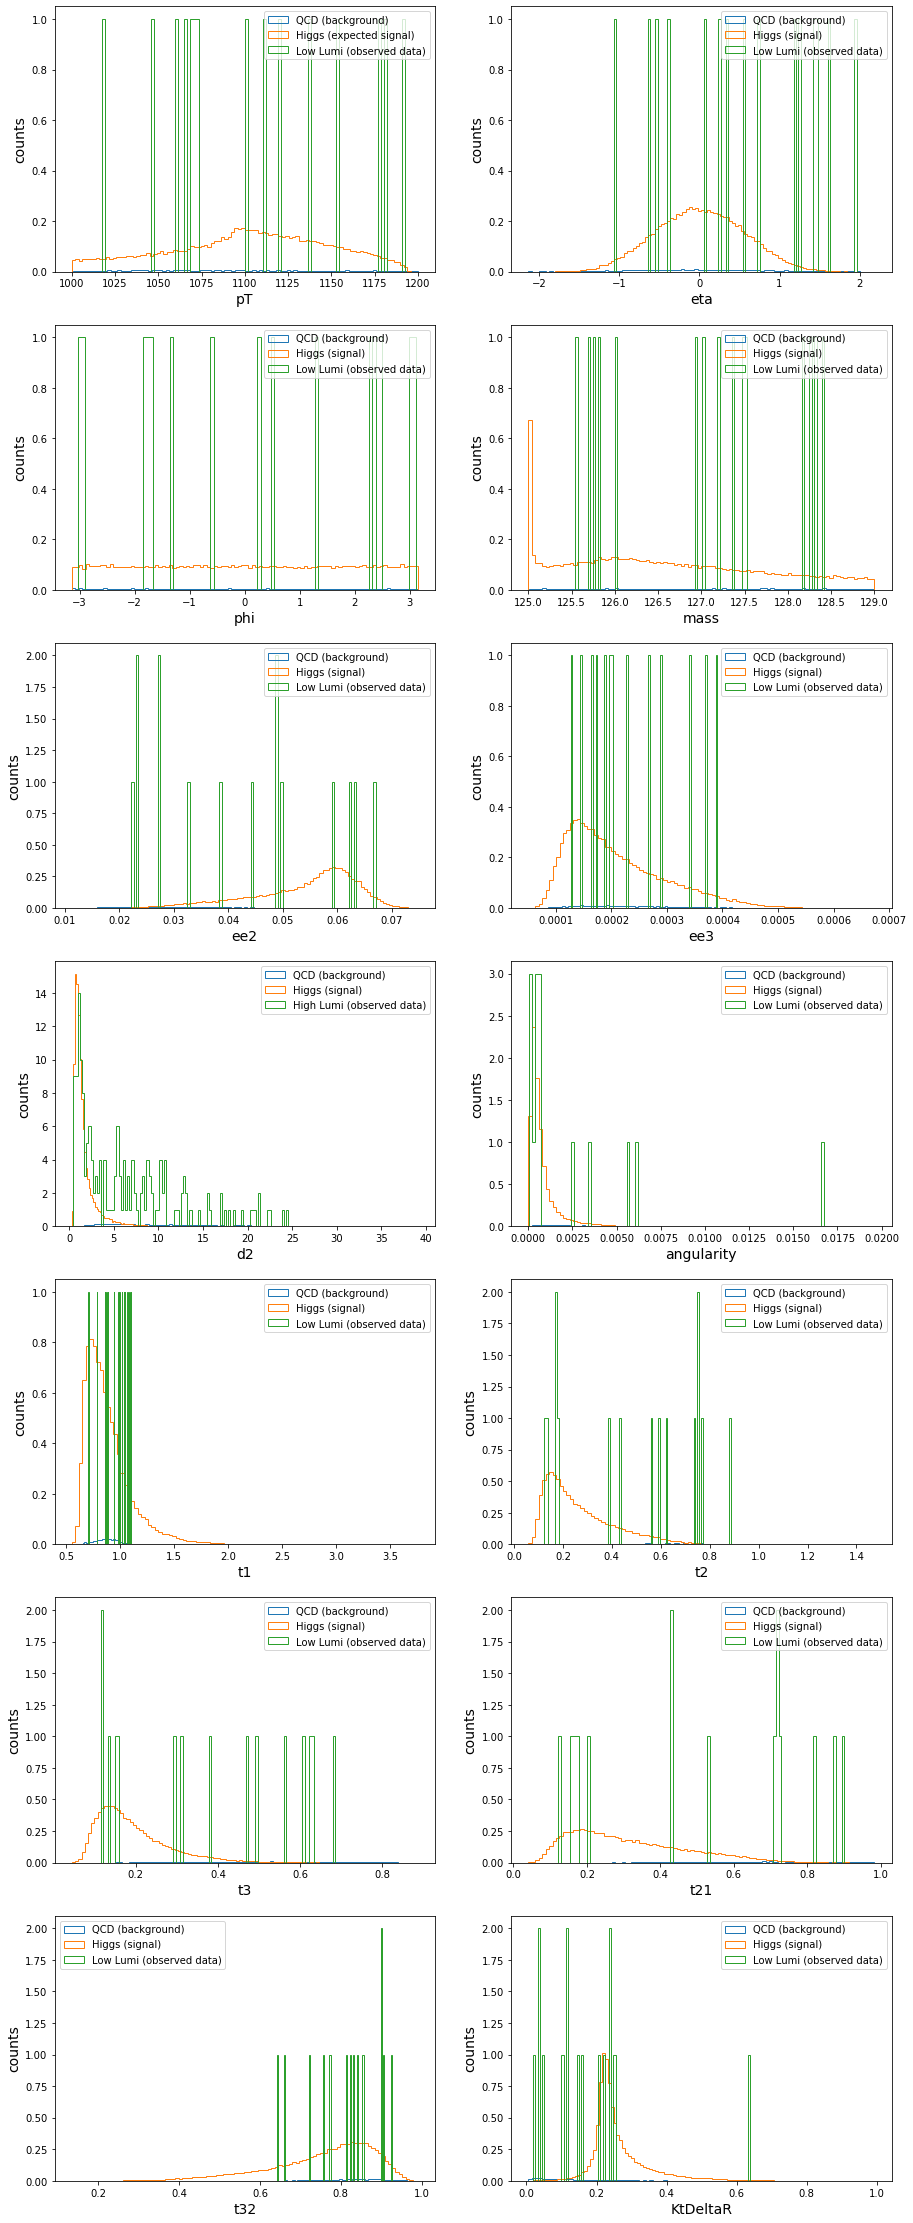

In [34]:
# create a figure with 14 subplots
fig, ax = plt.subplots(7, 2, figsize= (15, 40))

ax[0,0].hist(pt_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(pt_qcd[optimal_qcd].size,optimal_lowLumi_weight));
ax[0,0].hist(pt_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (expected signal)"], weights = np.full(pt_higgs[optimal_higgs].size,optimal_lowLumi_weight));
ax[0,0].hist(pt_lowLumi[optimal_lowLumi], bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[0,0].legend();
ax[0,0].set_xlabel("pT", fontsize = 14);
ax[0,0].set_ylabel("counts", fontsize = 14);

ax[0,1].hist(eta_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(eta_qcd[optimal_qcd].size, optimal_lowLumi_weight));
ax[0,1].hist(eta_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(eta_higgs[optimal_higgs].size,optimal_lowLumi_weight));
ax[0,1].hist(eta_lowLumi[optimal_lowLumi], bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[0,1].legend();
ax[0,1].set_xlabel("eta", fontsize = 14);
ax[0,1].set_ylabel("counts", fontsize = 14);

ax[1,0].hist(phi_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(phi_qcd[optimal_qcd].size, optimal_lowLumi_weight));
ax[1,0].hist(phi_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(phi_higgs[optimal_higgs].size,optimal_lowLumi_weight));
ax[1,0].hist(phi_lowLumi[optimal_lowLumi], bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[1,0].legend();
ax[1,0].set_xlabel("phi", fontsize = 14);
ax[1,0].set_ylabel("counts", fontsize = 14);

ax[1,1].hist(mass_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(mass_qcd[optimal_qcd].size, optimal_lowLumi_weight));
ax[1,1].hist(mass_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(mass_higgs[optimal_higgs].size, optimal_lowLumi_weight));
ax[1,1].hist(mass_lowLumi[optimal_lowLumi], bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[1,1].legend();
ax[1,1].set_xlabel("mass", fontsize = 14);
ax[1,1].set_ylabel("counts", fontsize = 14);

ax[2,0].hist(ee2_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(ee2_qcd[optimal_qcd].size, optimal_lowLumi_weight));
ax[2,0].hist(ee2_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(ee2_higgs[optimal_higgs].size, optimal_lowLumi_weight));
ax[2,0].hist(ee2_lowLumi[optimal_lowLumi], bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[2,0].legend();
ax[2,0].set_xlabel("ee2", fontsize = 14);
ax[2,0].set_ylabel("counts", fontsize = 14);

ax[2,1].hist(ee3_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(ee3_qcd[optimal_qcd].size, optimal_lowLumi_weight));
ax[2,1].hist(ee3_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(ee3_higgs[optimal_higgs].size, optimal_lowLumi_weight));
ax[2,1].hist(ee3_lowLumi[optimal_lowLumi], bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[2,1].legend();
ax[2,1].set_xlabel("ee3", fontsize = 14);
ax[2,1].set_ylabel("counts", fontsize = 14);

ax[3,0].hist(d2_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(d2_qcd[optimal_qcd].size, optimal_weight));
ax[3,0].hist(d2_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(d2_qcd[optimal_higgs].size, optimal_weight));
ax[3,0].hist(d2_highLumi[optimal_highLumi], bins = 100, histtype = "step", label = ["High Lumi (observed data)"]);
ax[3,0].legend();
ax[3,0].set_xlabel("d2", fontsize = 14);
ax[3,0].set_ylabel("counts", fontsize = 14);

ax[3,1].hist(angularity_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(angularity_qcd[optimal_qcd].size, optimal_lowLumi_weight));
ax[3,1].hist(angularity_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(angularity_higgs[optimal_higgs].size, optimal_lowLumi_weight));
ax[3,1].hist(angularity_lowLumi[optimal_lowLumi], bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[3,1].legend();
ax[3,1].set_xlabel("angularity", fontsize = 14);
ax[3,1].set_ylabel("counts", fontsize = 14);

ax[4,0].hist(t1_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(t1_qcd[optimal_qcd].size, optimal_lowLumi_weight));
ax[4,0].hist(t1_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(t1_higgs[optimal_higgs].size, optimal_lowLumi_weight));
ax[4,0].hist(t1_lowLumi[optimal_lowLumi], bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[4,0].legend();
ax[4,0].set_xlabel("t1", fontsize = 14);
ax[4,0].set_ylabel("counts", fontsize = 14);

ax[4,1].hist(t2_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(t2_qcd[optimal_qcd].size, optimal_lowLumi_weight));
ax[4,1].hist(t2_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(t2_higgs[optimal_higgs].size, optimal_lowLumi_weight));
ax[4,1].hist(t2_lowLumi[optimal_lowLumi], bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[4,1].legend();
ax[4,1].set_xlabel("t2", fontsize = 14);
ax[4,1].set_ylabel("counts", fontsize = 14);

ax[5,0].hist(t3_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(t3_qcd[optimal_qcd].size, optimal_lowLumi_weight));
ax[5,0].hist(t3_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(t3_higgs[optimal_higgs].size, optimal_lowLumi_weight));
ax[5,0].hist(t3_lowLumi[optimal_lowLumi], bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[5,0].legend();
ax[5,0].set_xlabel("t3", fontsize = 14);
ax[5,0].set_ylabel("counts", fontsize = 14);

ax[5,1].hist(t21_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(t21_qcd[optimal_qcd].size, optimal_lowLumi_weight));
ax[5,1].hist(t21_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(t21_higgs[optimal_higgs].size, optimal_lowLumi_weight));
ax[5,1].hist(t21_lowLumi[optimal_lowLumi], bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[5,1].legend();
ax[5,1].set_xlabel("t21", fontsize = 14);
ax[5,1].set_ylabel("counts", fontsize = 14);

ax[6,0].hist(t32_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(t32_qcd[optimal_qcd].size, optimal_lowLumi_weight));
ax[6,0].hist(t32_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(t32_higgs[optimal_higgs].size, optimal_lowLumi_weight));
ax[6,0].hist(t32_lowLumi[optimal_lowLumi], bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[6,0].legend();
ax[6,0].set_xlabel("t32", fontsize = 14);
ax[6,0].set_ylabel("counts", fontsize = 14);

ax[6,1].hist(KtDeltaR_qcd[optimal_qcd], bins = 100, histtype = "step", label = ["QCD (background)"], weights = np.full(KtDeltaR_qcd[optimal_qcd].size, optimal_lowLumi_weight));
ax[6,1].hist(KtDeltaR_higgs[optimal_higgs], bins = 100, histtype = "step", label = ["Higgs (signal)"], weights = np.full(KtDeltaR_higgs[optimal_higgs].size, optimal_lowLumi_weight));
ax[6,1].hist(KtDeltaR_lowLumi[optimal_lowLumi], bins = 100, histtype = "step", label = ["Low Lumi (observed data)"]);
ax[6,1].legend();
ax[6,1].set_xlabel("KtDeltaR", fontsize = 14);
ax[6,1].set_ylabel("counts", fontsize = 14);

### C. Evaluate observed significance and compare your results to expectation

In [60]:
# Write a function that calculate observed significance for a given mass cut
def evalObservedSig_lowLumi_mass(low, high, total = 100000): # 2 parameters: lower and higher bound of the mass cut
    
    # calculate N_higgs in this mass cut 
    counts_higgs = 0
    for i in mass_higgs:
        if (i > low and i <= high):
            counts_higgs = counts_higgs + 1
            
    # calculate number of observed data in this mass cut
    counts_lowLumi = 0
    for k in mass_lowLumi:
        if (k > low and k <= high):
            counts_lowLumi = counts_lowLumi + 1
            
    # renormalization
    N_higgs = counts_higgs* (50 / total)
    N_qcd = counts_lowLumi * (2000 / 442)
    
    sig = N_higgs / np.sqrt(N_qcd)
    
    return sig

In [61]:
print("Expected significance in mass cut (125,129): " + str(round(evalSig_mass(125,129),3)))
print("Observed significance in mass cut (125,129): " + str(round(evalObservedSig_lowLumi_mass(125,129),3)))

Expected significance in mass cut (125,129): 4.335
Observed significance in mass cut (125,129): 3.74


## 3. 95% Confidence Level of signal yields. In the low luminosity data, the observed significance is less than 5 σ . We will calculate the 95% confidence level upper limit of signal yield.
I will be using the mass feature for this part of the lab.
### A. Evaluate the expected 95% confidence level upper limit

In [68]:
#create 95% confidence interval for population mean weight
expectedCI = st.t.interval(alpha=0.95, df=len(mass_higgs)-1, loc=np.mean(mass_higgs), scale=st.sem(mass_higgs)) 
print("The expected 95% confidence level is: " + str(expectedCI))

The expected 95% confidence level is: (126.6117192887794, 126.7159451607726)


### B. Evaluate the observed 95% confidence level upper limit

In [69]:
observedCI = st.t.interval(alpha=0.95, df=len(mass_lowLumi)-1, loc=np.mean(mass_lowLumi), scale=st.sem(mass_lowLumi)) 
print("The observed 95% confidence level is: " + str(observedCI))

The observed 95% confidence level is: (162.521716964856, 179.743391977059)


### C. Compare expectation to observation. Comment on your finding.
The upper limit of the observed confidence level is higher than the expected.